In [2]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
# import mlflow

In [4]:
with open("../../names.txt", "r") as f:
    names = f.read().splitlines()

In [5]:
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

![](./Screenshot%202023-07-05%20at%2012.13.13.png)

In [26]:
class MLP(nn.Module):
    """
    Based on Bengio et al. 2003. See local copy at `./bengio03a.pdf`
    https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
    
    Letter level tokens are looked up in an embedding table.
    Embedding vectors are then fed into a n-dimensional hidden layer. 
    Finally a softmax is applied to the output layer, producing a probability
    distribution over all possible next tokens in the sequence
    
    A blocksize variable is used to determine the number of context characters
    to use. This allows for a fixed sized hidden layer.
    """
    def __init__(self, blocksize, embedding_dimension, vocab_size, hidden_layer_size):
        super().__init__()
        self.blocksize = blocksize
        self.embedding_dimension = embedding_dimension
        self.hidden_layer_input_size = self.blocksize * self.embedding_dimension
        # token embeddings
        self.C = nn.Parameter(torch.randn(vocab_size, embedding_dimension))
        # hidden layer
        self.W = nn.Parameter(torch.randn(self.hidden_layer_input_size, hidden_layer_size))
        self.d = nn.Parameter(torch.zeros(hidden_layer_size)) 
        # output layer
        self.U = nn.Parameter(torch.randn(hidden_layer_size, vocab_size))
        self.b = nn.Parameter(torch.zeros(vocab_size))
        
        
    def forward(self, x, targets=None):
        embeddings = self.C[x]
        # use view to arrange all of the embeddings into a column vector for
        # each example. With batches this will be a [bs, concat_embeddings]
        # sized matrix
        h = (embeddings.view(-1, self.hidden_layer_input_size) @ self.W + self.d).tanh()
        logits = h @ self.U + self.b
        preds = F.softmax(logits, dim=1)
        
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits, targets)
        
        return preds, loss

In [27]:
def get_batches(*tensors, batch_size):
    assert len(set([t.shape[0] for t in tensors])) == 1, "All tensors must have the same number of rows"
    
    for i in range(0, tensors[0].shape[0] // batch_size):
        batch_start = i * batch_size
        batch_end = batch_start + batch_size
        yield tuple([t[batch_start : batch_end] for t in tensors])

In [28]:
def split_data(array):
    frac = array.shape[0] * 0.1 // 1
    train = array[:int(frac * 8)]
    val = array[int(frac * 8): int(frac * 9)]
    test = array[int(frac * 9):]
    assert train.shape[0] + test.shape[0] + val.shape[0] == array.shape[0]
    return train, val, test

In [29]:
letters = sorted(list(set("".join(names))))
letters.insert(0, ".")
ltoi = {l:i for i, l in enumerate(letters)}
itol = {i:l for l, i in ltoi.items()}

In [33]:
# datasets
blocksize = 3
xs, ys = [], []
for n in names:
    n_padded = "." * blocksize + n + "."
    for i in range(len(n) + 1):
        xs.append([ltoi[z] for z in n_padded[i : i + blocksize]])
        ys.append(ltoi[n_padded[i + blocksize]])
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)

xtrain, xval, xtest = split_data(xs)
ytrain, yval, ytest = split_data(ys)

m = MLP(
    blocksize=blocksize,
    embedding_dimension=20,
    vocab_size=27,
    hidden_layer_size=100
)

In [34]:
losses = []
epochs = 30
lr = 1e-1

find_lr = False
lrs = torch.logspace(-5, 0, epochs)
bs = 32

for i in range(epochs):
    for xbatch, ybatch in get_batches(xtrain, ytrain, batch_size=bs):
        preds, loss = m(xbatch, ybatch)
        
        m.zero_grad()
        loss.backward()
        
        
        if find_lr:
            epoch_lr = lrs[i]
        else:
            epoch_lr = lr if i <= 0.5 * epochs else lr * 0.2
            
        for p in m.parameters():
            p.data += -epoch_lr * p.grad.data
        
    _, val_loss = m(xval, yval)
    print(val_loss.item(), epoch_lr)

    losses.append(val_loss.item())


2.8416688442230225 0.1
2.622138261795044 0.1
2.5594422817230225 0.1
2.5266711711883545 0.1
2.5069942474365234 0.1
2.494065761566162 0.1
2.483363151550293 0.1
2.475870370864868 0.1
2.474015474319458 0.1
2.470193862915039 0.1
2.4651033878326416 0.1
2.4604196548461914 0.1
2.457545280456543 0.1
2.455993890762329 0.1
2.4545724391937256 0.1
2.45381236076355 0.1
2.3344271183013916 0.020000000000000004
2.335831880569458 0.020000000000000004
2.336484909057617 0.020000000000000004
2.336735963821411 0.020000000000000004
2.336778402328491 0.020000000000000004
2.3367011547088623 0.020000000000000004
2.3365516662597656 0.020000000000000004
2.33636212348938 0.020000000000000004
2.3361499309539795 0.020000000000000004
2.3359227180480957 0.020000000000000004
2.3356845378875732 0.020000000000000004
2.3354358673095703 0.020000000000000004
2.335176944732666 0.020000000000000004
2.3349075317382812 0.020000000000000004


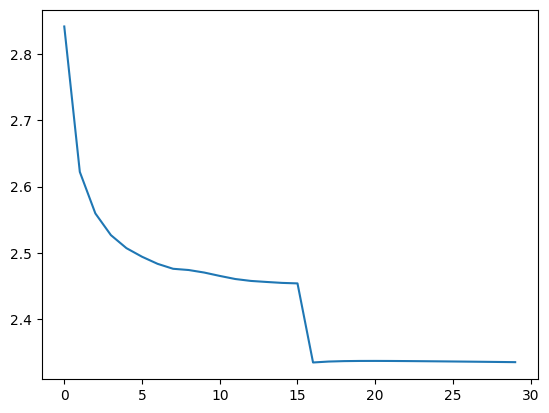

In [35]:
plt.plot(range(epochs), losses)

blocksize=3,
embedding_dimension=10,
vocab_size=27,
hidden_layer_size=50
val_loss=2.368145227432251

blocksize=3,
embedding_dimension=20,
vocab_size=27,
hidden_layer_size=50
val_loss=2.366750478744507
